In [1]:
#!/usr/bin/env python3
%matplotlib inline

# Basic import
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint


# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F

# Import models
from models import LSTM

# Import training and evaluating functions
from training import train
from pi_training import pi_train

# Import functions for physical informed training
from pi_functions import L63_field, PILoss

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

# Optuna
import optuna
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour


#Import sys
import sys

## Dataset generation

Text(0.5, 0.92, 'Validation dataset')

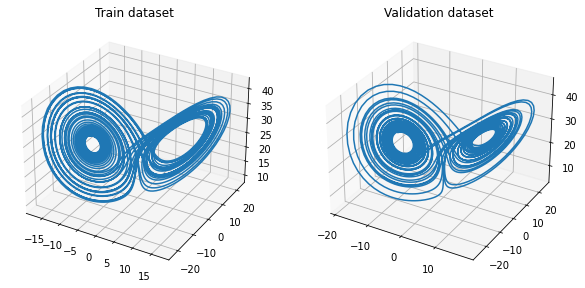

In [2]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

# Train dataset (discard first 100 steps)
state0 = [1.0, 1.0, 1.0]
train_steps = 4000
t_train = np.arange(0.0, (100+train_steps)*dt, dt)
train_dataset = odeint(f, state0, t_train)

# Validation dataset (different ic, discard first 100 steps)
state1 = [2.0, 0.0, 3.0]
val_steps = 4000
t_val = np.arange(0.0, (100+val_steps)*dt, dt)
val_dataset = odeint(f, state1, t_val)

fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot(train_dataset[100:, 0], train_dataset[100:, 1], train_dataset[100:, 2])
ax1.set_title("Train dataset")
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot(val_dataset[100:, 0], val_dataset[100:, 1], val_dataset[100:, 2])
ax2.set_title("Validation dataset")



In [3]:
### Convert to tensor
l_seq = 20
num_sequences = int(4000/l_seq)

train_states = torch.tensor(train_dataset[100:], requires_grad=True,dtype=torch.float)
train_states = torch.reshape(train_states, (num_sequences, l_seq, 3))
val_states = torch.tensor(val_dataset[100:], requires_grad=False,dtype=torch.float)
val_states = torch.reshape(val_states, (num_sequences, l_seq, 3))


### Dataloader
train_dataloader = DataLoader(train_states, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_states, batch_size=16, shuffle=True)


## Purely data driven approach

In [ ]:
# Define network
input_size = 3
hidden_units = 10
layers_num = 2
drop_p = 0.3
net_dd = LSTM(input_size, hidden_units, layers_num, drop_p)

# Define the optimizer
optimizer = optim.Adam(net_dd.parameters())

# Define the loss function
loss_fn = nn.MSELoss()

#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_dd.to(device)

### Training
max_num_epochs = 2000
early_stopping = False
train_loss, val_loss = train(net_dd, device, train_dataloader, val_dataloader, loss_fn, optimizer, max_num_epochs, early_stopping)
  

In [ ]:
### Plot losses
plt.semilogy(train_loss, label="Train loss")
plt.semilogy(val_loss, label="Validation loss")
plt.legend()

In [ ]:
### Find initial state of the RNN

# Prepare input
seed_input = torch.tensor((1,1,1), dtype=torch.float).unsqueeze(0).unsqueeze(0)
seed_input = seed_input.to(device)
net_dd.eval()

with torch.no_grad():
    # Forward pass
    net_out, initial_net_state = net_dd(seed_input)
    
print(net_out.shape)
print(initial_net_state[0].shape)

### Generate a trajectory with network

net_input = torch.tensor((1,1,1), dtype=torch.float).unsqueeze(0).unsqueeze(0)
net_state = initial_net_state

net_states = []
for i in range(4000):
    with torch.no_grad():
        net_input = net_input.to(device)
    
        # Forward pass
        net_input, net_state = net_dd(net_input, net_state)
        
        net_states.append(net_input[-1].squeeze().numpy())

In [ ]:
net_states = np.array(net_states)
print(net_states.shape)

fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
ax1.plot(net_states[100:, 0], net_states[100:, 1], net_states[100:, 2])
ax1.set_title("Generated dynamics")
ax2.plot(train_dataset[100:, 0],train_dataset[100:, 1], train_dataset[100:, 2])
ax2.set_title("Train dynamics")

## Physical informed dynamics

Network initialized


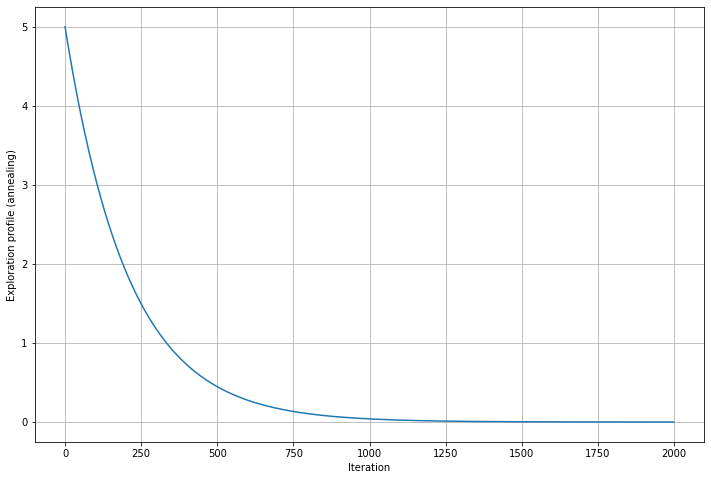

In [4]:
# Define network
input_size = 3
hidden_units = 10
layers_num = 2
drop_p = 0.3
net_pi = LSTM(input_size, hidden_units, layers_num, drop_p)

# Iterate through the dataloader for "num_epochs"
max_num_epochs = 2000

### Define exploration profile
initial_value = 5
exp_decay = np.exp(-np.log(initial_value) / max_num_epochs * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
annealing = [initial_value * (exp_decay ** i) for i in range(max_num_epochs)]
### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(annealing)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (annealing)')

# Define vector field
field = L63_field(rho = 28.0, sigma = 10.0, beta = 8.0/3.0)

# Define the optimizer
optimizer = optim.Adam(net_pi.parameters())

# Define loss functions
loss_fn = PILoss(dt,field, annealing)

In [18]:
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_pi.to(device)

### Training
early_stopping = False
train_loss, val_loss = pi_train(net_pi, device, train_dataloader, val_dataloader, loss_fn, optimizer, max_num_epochs, early_stopping)


Training device: cpu


Train loss: 1.61, Val loss 0.74:  16%|█▏     | 324/2000 [00:19<01:38, 17.00it/s]


KeyboardInterrupt: 

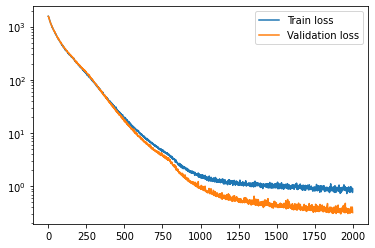

In [6]:
### Plot losses
plt.semilogy(train_loss, label="Train loss")
plt.semilogy(val_loss, label="Validation loss")
plt.legend()

In [27]:
### Find initial state of the RNN

# Prepare input
seed_input = torch.tensor((1,1,1), dtype=torch.float).unsqueeze(0).unsqueeze(0)
seed_input = seed_input.to(device)
net_pi.eval()

with torch.no_grad():
    # Forward pass
    net_out, initial_net_state = net_pi(seed_input)
    
print(net_out.shape)
print(initial_net_state[0].shape)

### Generate a trajectory with network

net_input = torch.tensor((1,1,1), dtype=torch.float).unsqueeze(0).unsqueeze(0)
net_state = initial_net_state

net_states = []
for i in range(400):
    with torch.no_grad():
        net_input = net_input.to(device)
    
        # Forward pass
        net_input, net_state = net_pi(net_input, net_state)
        
        net_states.append(net_input[-1].squeeze().numpy())


torch.Size([1, 1, 3])
torch.Size([2, 1, 10])


(400, 3)


Text(0.5, 0.92, 'Train dynamics')

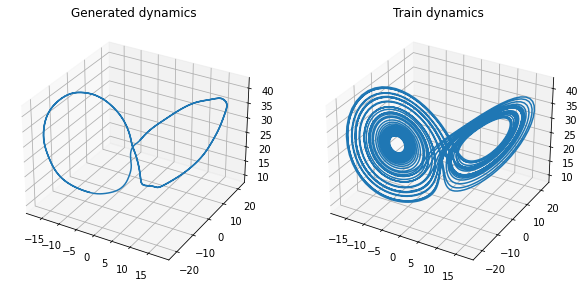

In [28]:
net_states = np.array(net_states)
print(net_states.shape)

fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
ax1.plot(net_states[100:, 0], net_states[100:, 1], net_states[100:, 2])
ax1.set_title("Generated dynamics")
ax2.plot(train_dataset[100:, 0],train_dataset[100:, 1], train_dataset[100:, 2])
ax2.set_title("Train dynamics")

## Lyapunov exponents prediction

In [ ]:
### Dataset generation

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

eps = 0.01 # Perturbation
len_seq = 5 # Length of the pertubed sequence
t = np.arange(0.0, dt*len_seq, dt) # Time array

# Add pertubation dimension and dynamics dimension
print(states_dataset.shape) 
pd = np.expand_dims(states_dataset, axis=1)
pd = np.expand_dims(pd, axis=1)
perturbed_dataset = np.concatenate((pd, pd), axis=2)
perturbed_dataset = np.concatenate((perturbed_dataset, pd), axis=2)
print(perturbed_dataset.shape)


# Add perturbation
for i in range(3):
    perturbed_dataset[:,:,i,i] += eps
    
print(perturbed_dataset[0,:,0,:])

le_dataset = []
# Run the dynamics for all perturbations for len_seq steps
for state in perturbed_dataset:
    ev_dyn0 = np.expand_dims(odeint(f, state[0,0,:], t), axis=1)
    ev_dyn1 = np.expand_dims(odeint(f, state[0,1,:], t), axis=1)
    ev_dyn2 = np.expand_dims(odeint(f, state[0,2,:], t), axis=1)
   
    ev_dyn = np.concatenate((ev_dyn0, ev_dyn1), axis=1)
    ev_dyn = np.concatenate((ev_dyn, ev_dyn2), axis=1)
    le_dataset.append(ev_dyn)

# Convert to numpy
le_dataset = np.array(le_dataset)

In [ ]:
### Convert to tensor
l_seq = 20
num_sequences = int(4000/l_seq)

le_dataset = torch.tensor(le_dataset, requires_grad=True,dtype=torch.float)


### Dataloader
le_dataloader = DataLoader(le_dataset, batch_size=16, shuffle=True)
print(next(iter(le_dataloader)).shape)

### Trainig

In [ ]:
# Define network
input_size = 3
hidden_units = 10
layers_num = 2
drop_p = 0.3
net_le = LSTM(input_size, hidden_units, layers_num, drop_p)

In [ ]:
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_pi.to(device)
# Network in training mode (enable stochastic layers, e.g. dropout)
net_pi.train()



# Create pbar 
pbar = tqdm(range(num_epochs))

for epoch_num in pbar:
    epoch_losses = []
    
    i = 0
    for batch_sample in le_dataloader:
        
        ### Move samples to the proper device
        batch_sample = batch_sample.to(device)

        ### Prepare network input and labels
        net_input  = batch_sample[:, :-1, :]
        labels = batch_sample[:, 1:, :]

        ### Forward pass
        # Clear previous recorded gradients
        optimizer.zero_grad()
        # Forward pass
        net_out, _ = net_pi(net_input) # we do not need the rnn state at this point, we can ignore the output with "_"
    
        ### Update network
        # Evaluate data driven loss
        dd_loss = loss_fn(net_out, labels)
        # Evaluate physical informed loss
        pi_loss = piloss_fn(net_input,net_out)
        
        loss = beta[i]*dd_loss + pi_loss
    
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Save batch loss
        epoch_losses.append(loss.data.cpu().numpy())
        
        # Update counter
        i = i+1
        
  
    # Compute epoch loss
    epoch_loss = np.mean(epoch_losses)
    
    # Set description
    pbar.set_description("Train loss: %s" %round(np.mean(epoch_losses),3))
    
    # Append
    log_loss.append(epoch_loss)
